In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install onnx
!pip install torch

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-y8fj5t6r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-y8fj5t6r
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=f0686950e5890fe973e78519eeb36b32e43eeeb7d66593376954099ec5ae1964
  Stored in directory: /tmp/pip-ephem-wheel-cache-94e05lrx/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from segment_anything import sam_model_registry
from segment_anything.utils.onnx import SamOnnxModel
import torch

In [3]:
# Download SAM model checkpoint
!pip install wget
!python -m wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b6bd922659f6152589f736a3e7c7625b4a71d8bd4b81c4c3651081a8b3b57c72
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget

Saved under sam_vit_b_01ec64.pth


In [4]:
# Load SAM model
sam = sam_model_registry["vit_b"](checkpoint="./sam_vit_b_01ec64.pth")

In [5]:
# Export images encoder from SAM model to ONNX
torch.onnx.export(
    f="vit_b_encoder.onnx",
    model=sam.image_encoder,
    args=torch.randn(1, 3, 1024, 1024),
    input_names=["images"],
    output_names=["embeddings"],
    export_params=True
)

/usr/local/lib/python3.11/dist-packages/segment_anything/modeling/image_encoder.py:258: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if pad_h > 0 or pad_w > 0:
/usr/local/lib/python3.11/dist-packages/segment_anything/modeling/image_encoder.py:304: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  max_rel_dist = int(2 * max(q_size, k_size) - 1)
/usr/local/lib/python3.11/dist-packages/segment_anything/modeling/image_encoder.py:304: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of 

In [6]:
# Export mask decoder from SAM model to ONNX
onnx_model = SamOnnxModel(sam, return_single_mask=True)
embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]
torch.onnx.export(
    f="vit_b_decoder.onnx",
    model=onnx_model,
    args=tuple(dummy_inputs.values()),
    input_names=list(dummy_inputs.keys()),
    output_names=output_names,
    dynamic_axes={
        "point_coords": {1: "num_points"},
        "point_labels": {1: "num_points"}
    },
    export_params=True,
    opset_version=17,
    do_constant_folding=True
)

/usr/local/lib/python3.11/dist-packages/segment_anything/modeling/transformer.py:232: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  attn = attn / math.sqrt(c_per_head)
/usr/local/lib/python3.11/dist-packages/segment_anything/utils/onnx.py:97: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  score_reweight = torch.tensor(
/usr/local/lib/python3.11/dist-packages/torch/onnx/symbolic_opset9.py:5383: UserWarning: Exporting aten::index operator of advanced indexing in opset 17 is achieved by combination of multiple ONNX opera

In [9]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib onnx onnxruntime


!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: False
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.1 MB/s eta 0:00:00
--2025-04-18 06:36:24--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271475 (265K) [image/jpeg]
Saving to: ‘images/truck.jpg’

truck.jpg           100%[===================>] 265.11K  --.-KB/s    in 0.04s   

2025-04-18 06:36:24 (6.79 MB/s) - ‘images/truck.jpg’ saved [271475/271475]



In [10]:
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

In [12]:
onnx_model_encoder_quantized_path = "sam_encoder_onnx_quantized_example.onnx"
quantize_dynamic(
    model_input='/content/vit_b_encoder.onnx',
    model_output=onnx_model_encoder_quantized_path,
    # optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)

  elem_type: 7
  shape {
    dim {
      dim_param: "unk__3"
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_param: "unk__75"
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_param: "unk__202"
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_param: "unk__284"
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_param: "unk__411"
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_param: "unk__493"
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_param: "unk__620"
    }
    dim {
      dim_value: 2
    }
  }
}
.
  elem_type: 7
  shape {
    dim {
      dim_param: "unk__702"
    }
    dim {
      dim_value: 2
    }
  }
}
.


In [13]:
onnx_model_encoder_quantized_path = "sam_decoder_onnx_quantized_example.onnx"
quantize_dynamic(
    model_input='/content/vit_b_decoder.onnx',
    model_output=onnx_model_encoder_quantized_path,
    # optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)

In [14]:
!ls -lh

total 816M
drwxr-xr-x 2 root root 4.0K Apr 18 06:36 images
-rw-r--r-- 1 root root 4.6M Apr 18 06:39 sam_decoder_onnx_quantized_example.onnx
-rw-r--r-- 1 root root  96M Apr 18 06:38 sam_encoder_onnx_quantized_example.onnx
drwxr-xr-x 1 root root 4.0K Apr 16 13:40 sample_data
-rw-r--r-- 1 root root 358M Apr 18 06:31 sam_vit_b_01ec64.pth
-rw-r--r-- 1 root root  16M Apr 18 06:33 vit_b_decoder.onnx
-rw-r--r-- 1 root root 343M Apr 18 06:33 vit_b_encoder.onnx


In [16]:
!pip install Pillow
!pip install numpy

In [17]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from copy import deepcopy

In [30]:
# LOAD IMAGE
!wget https://github.com/AndreyGermanov/sam_onnx_full_export/blob/main/cat_dog.jpg
img = Image.open("cat_dog.jpg").convert("RGB")
img.size

--2025-04-18 06:53:00--  https://github.com/AndreyGermanov/sam_onnx_full_export/blob/main/cat_dog.jpg
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘cat_dog.jpg.1’

cat_dog.jpg.1           [ <=>                ] 201.22K  --.-KB/s    in 0.1s    

2025-04-18 06:53:00 (2.03 MB/s) - ‘cat_dog.jpg.1’ saved [206049]



(612, 415)

In [19]:
# 1. PREPROCESS IMAGE FOR ENCODER

# Resize image preserving aspect ratio using 1024 as a long side
orig_width, orig_height = img.size
resized_width, resized_height = img.size

if orig_width > orig_height:
    resized_width = 1024
    resized_height = int(1024 / orig_width * orig_height)
else:
    resized_height = 1024
    resized_width = int(1024 / orig_height * orig_width)

img = img.resize((resized_width, resized_height), Image.Resampling.BILINEAR)

img.size

(1024, 694)

In [20]:
# Prepare input tensor from image
input_tensor = np.array(img)

# Normalize input tensor numbers
mean = np.array([123.675, 116.28, 103.53])
std = np.array([[58.395, 57.12, 57.375]])
input_tensor = (input_tensor - mean) / std

# Transpose input tensor to shape (Batch,Channels,Height,Width
input_tensor = input_tensor.transpose(2,0,1)[None,:,:,:].astype(np.float32)

input_tensor.shape

(1, 3, 694, 1024)

In [21]:
# Make image square 1024x1024 by padding short side by zeros
if resized_height < resized_width:
    input_tensor = np.pad(input_tensor,((0,0),(0,0),(0,1024-resized_height),(0,0)))
else:
    input_tensor = np.pad(input_tensor,((0,0),(0,0),(0,0),(0,1024-resized_width)))

input_tensor.shape

(1, 3, 1024, 1024)

In [23]:
# 2. GET IMAGE EMBEDDINGS USING IMAGE ENCODER
encoder = ort.InferenceSession("/content/sam_encoder_onnx_quantized_example.onnx")
outputs = encoder.run(None,{"images":input_tensor})
embeddings = outputs[0]

embeddings.shape

(1, 256, 64, 64)

In [26]:
# ENCODE PROMPT (single point)
input_point = np.array([[321,230]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])])[None, :].astype(np.float32)

coords = deepcopy(onnx_coord).astype(float)
coords[..., 0] = coords[..., 0] * (resized_width / orig_width)
coords[..., 1] = coords[..., 1] * (resized_height / orig_height)

onnx_coord = coords.astype("float32")
onnx_coord

array([[[537.098 , 384.6265],
        [  0.    ,   0.    ]]], dtype=float32)

In [27]:
# RUN DECODER TO GET MASK
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

decoder = ort.InferenceSession("/content/sam_decoder_onnx_quantized_example.onnx")
masks,_,_ = decoder.run(None,{
    "image_embeddings": embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array([orig_height, orig_width], dtype=np.float32)
})

In [28]:
# POSTPROCESS MASK
mask = masks[0][0]
mask = (mask > 0).astype('uint8')*255
mask.shape

(415, 612)

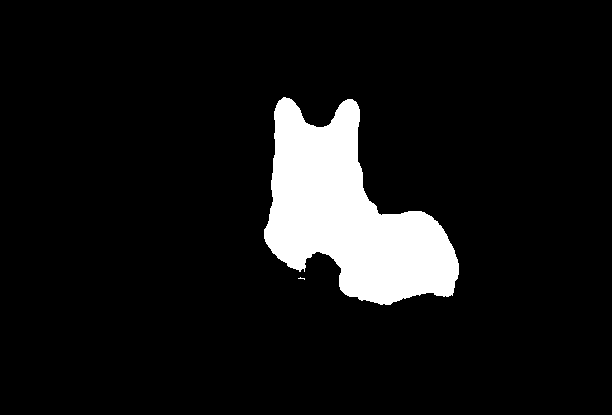

In [29]:
# VISUALIZE MASK
img_mask = Image.fromarray(mask,"L")
img_mask